## Polymer Project: 
## Implementation of the pivot algorithm to simulate Self-avoiding-random walks

 Names: Mandus Aldag, Alexandros Mylanos

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time
from tqdm import tqdm


In [2]:
def check_self_avoidance(coords, pivot = None):
    # False = Self avoidant
    # True = not Self avoidant

    if pivot == None:
        N = np.size(coords, axis=1)
        hashset = set()
        for i in range(N):
            tmp_tuple = tuple(coords[:,i])
            if tmp_tuple in hashset:
                return True
            else:
                hashset.add(tmp_tuple)
                
        
        return False
    
    else:
        N = np.size(coords, axis=1)
        if pivot >= N//2:
            longer_site= pivot 
            shorter_site= N-pivot-1
            dir = -1
        else:
            longer_site = N-pivot-1
            shorter_site = pivot
            dir = 1
       
        hashset=set()
        for i in range(1,longer_site+1):
            if i > shorter_site:   # Case when we scan only in the longer direction from the pivot because the short direction was already fully scanned
                tmp_tuple = tuple(coords[:,pivot+i*dir])
                if tmp_tuple in hashset:
                    return True
                else:
                    hashset.add(tmp_tuple)
            else: # Check in both directions of the pivot
                tmp_tuple = tuple(coords[:,pivot+i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
                tmp_tuple = tuple(coords[:,pivot-i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
        return False
                    

In [3]:
def generate_random_walk(L):
    coord = np.zeros((2,L),dtype=int)
    for l in range(1,L):
        direction = np.random.randint(0,4) # clock wise starting from the top
        if direction == 0:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]+1 

        elif  direction == 1:
            coord[0,l] = coord[0,l-1]+1
            coord[1,l] = coord[1,l-1]
        
        elif  direction == 2:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]-1

        elif  direction == 3:
            coord[0,l] = coord[0,l-1]-1
            coord[1,l] =  coord[1,l-1]
    
    return coord
        

In [4]:
def initial_SAW(N: int): #Dimerisation
    if N <= 5:
        tmp = True
        while tmp:
            walk = generate_random_walk(N)
            tmp = check_self_avoidance(walk)
        return walk



    else:
        tmp = True
        while tmp:
            first = initial_SAW(N//2)
            second = initial_SAW(N-N//2+1)
            translated = (first[:,-1]+second.T).T
            concatenated = np.concatenate((first,translated[:,1:]),axis=1)
            tmp = check_self_avoidance(concatenated)

        return concatenated


In [5]:
def initial_SAW_rod(N: int):
    coord = np.zeros((2,N),dtype=int)
    for i in range(N):
        coord[0,i] = i
    return coord

test = initial_SAW_rod(10)[0,:]
test[:5]

array([0, 1, 2, 3, 4])

In [6]:
def symmetry_op(coord):
    N = np.size(coord,axis=1)
    g = np.random.randint(0,7)
    if g==0: #+90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[1,0]]), coord[:,i])
    elif g==1: #-90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[-1,0]]), coord[:,i])
    elif g==2: #180°
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,-1]]), coord[:,i])
    elif g==3: #x-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[1,0],[0,-1]]), coord[:,i])
    elif g==4: #y-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,1]]), coord[:,i])
    elif g==5: #diagonal reflection upperright-bottomleft
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[1,0]]), coord[:,i])
    elif g==6: #diagonal reflection upperleft-bottomright
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[-1,0]]), coord[:,i])
    if debug:
        print("g = ",g)
    return coord, g
    

In [7]:
def pivot_step(coord):
    global accepted
    N = np.size(coord,axis=1)
    pivot = np.random.randint(1,N)
    if debug:
        print("pivot = ",pivot)
    to_be_operated = coord[:,pivot:]
    to_be_operated = (to_be_operated.T-to_be_operated[:,0]).T
    operated, g = symmetry_op(to_be_operated)
    accepted[1,g] +=1
    operated = (operated.T+coord[:,pivot]).T

    coord_new = np.concatenate((coord[:,:pivot],operated),axis=1)
    not_selfavoidant = check_self_avoidance(coord_new,pivot)
    if not_selfavoidant:
        if debug:
            print("Not selfavoidant")
        return coord
    else:
        accepted[0,g] +=1
        return coord_new


In [8]:
def squared_end_to_end(coord):
    return np.linalg.norm(coord[:,-1])**2

def squared_gyration(coord):
    N = np.size(coord,axis=1)
    a = (1/N * np.sum(coord,axis=1))
    inbracket = np.dot(a,a)
    result = 0
    for i in range(N):
        result += np.dot(coord[:,i], coord[:,i])-inbracket
    return 1/N * result

In [9]:
def pivot_run(coord,iterations):
    global accepted
    ω_squared = []
    S_squared = []
    for i in tqdm(range(iterations)):
        coord = pivot_step(coord)
        ω_squared.append(squared_end_to_end(coord))
        S_squared.append(squared_gyration(coord))
    return ω_squared, S_squared, accepted

In [10]:
def autocorrelation(timeseries, mean=None):
    timeseries = np.array(timeseries)
    if mean is None:
        mean = timeseries.mean()
    fluctuations = timeseries-mean

    C = np.fft.ifft(np.fft.fft(fluctuations) * np.fft.ifft(fluctuations)).real
    return C/C[0]

def integrated_autocorrelation_time(timeseries, mean=None, until=None):
    steps = len(timeseries)
    if until is None:
        until = steps // 2
    Gamma = autocorrelation(timeseries, mean=mean)[:until]
    try:
        first_zero = np.where(Gamma <= 0)[0][0]
        print("First zero = ",first_zero)
        return 0.5 + Gamma[1:first_zero].sum()
    except:
        # Gamma never hits 0.  So the autocorrelation spans ~ the whole ensemble.
        return steps # at least!

In [11]:
def binning_analyis(data,kmax):
    M = len(data)
    error_est = []
    for k in range(1,kmax+1):
        M_k = M//k
        X_k = np.mean(np.reshape(data[:M_k*k],(-1,k)).T,axis=0)
        #print(len(X_k))
        error_est.append(np.std(X_k)/np.sqrt(M_k))
    τ = 0.5*((error_est[-1]/error_est[0])**2-1)
    return error_est, int(np.ceil(τ))

pivot =  3
g =  5
10.000000000000002


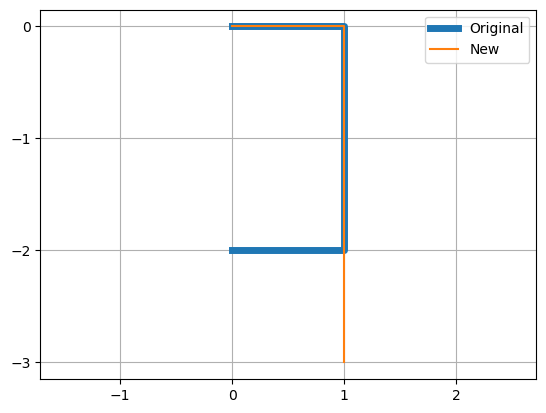

In [17]:
test = initial_SAW(5)
debug = 1
plt.plot(test[0,:],test[1,:],linewidth=5,label="Original")
new = pivot_step(test)
print(squared_end_to_end(new))
plt.plot(new[0,:],new[1,:],label="New")
ax = plt.gca() 
ax.xaxis.set_major_locator(MultipleLocator(1))  # X ticks every 1 unit
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.axis("equal")
plt.legend()
plt.grid()
plt.show()

# Preliminary Tests

In [ ]:
iterations = 10**7
N=16
coord = initial_SAW(N)
accepted = np.zeros(7)
debug = 0
ω_squared, S_squared,f = pivot_run(coord,iterations)

100%|██████████| 10000000/10000000 [06:46<00:00, 24601.48it/s]


Mean squared end-to-end distance is: 47.233436 ± 0.009237335889542378
Mean squared gyration radius is: 6.7823586875 ± 0.0007195143428142026
Universal ratio is: 0.1435923206497194
Acceptance rate f =  0.5809505


In [17]:
np.random.seed(4321)
iterations = 10**7
N=16
coord = initial_SAW(N)
accepted = np.zeros((2,7))
debug = 0
ω_squared, S_squared, accepted = pivot_run(coord,iterations)
f = np.sum(accepted[0,:])/np.sum(accepted[1,:])
f_ops = accepted[0,:]/accepted[1,:]
print(f)

100%|██████████| 10000000/10000000 [06:47<00:00, 24569.21it/s]

0.5810395


Error analysis and results:

In [18]:
error_ω_squared,τ_int_bin_ω_squared  = binning_analyis(ω_squared,300)
error_S_squared,τ_int_bin_S_squared  = binning_analyis(S_squared,300)
mean_ω_squared = np.mean(ω_squared)
mean_S_squared = np.mean(S_squared)
ur = mean_S_squared/mean_ω_squared


print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {error_ω_squared[-1]}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {error_S_squared[-1]}")
print(f"Universal ratio is: {ur}")
print(f"Acceptance rate f = ",f)
print(f"Autocorrelation time ω^2= ",τ_int_bin_ω_squared)
print(f"Autocorrelation time S^2= ",τ_int_bin_S_squared )

Mean squared end-to-end distance is: 47.1933868 ± 0.026909941028947088
Mean squared gyration radius is: 6.7844908109375 ± 0.00265304030574153
Universal ratio is: 0.14375935424362254
Acceptance rate f =  0.5810395
Autocorrelation time ω^2=  4
Autocorrelation time S^2=  7


# N=20

In [ ]:
np.random.seed(1234)
iterations = 10**7
N=21
coord = initial_SAW(N)
accepted = 0
debug = 0
ω_squared, S_squared,f = pivot_run(coord,iterations)

100%|██████████| 10000000/10000000 [08:27<00:00, 19709.15it/s]


In [22]:
np.random.seed(1234)
iterations = 10**7
N=21
coord = initial_SAW(N)
accepted = np.zeros((2,7))
debug = 0
ω_squared, S_squared, accepted = pivot_run(coord,iterations)
f = np.sum(accepted[0,:])/np.sum(accepted[1,:])
f_ops = accepted[0,:]/accepted[1,:]
print(f)

100%|██████████| 10000000/10000000 [08:17<00:00, 20112.65it/s]


0.5487302


In [ ]:

error_ω_squared,τ_int_bin_ω_squared  = binning_analyis(ω_squared,300)
error_S_squared,τ_int_bin_S_squared  = binning_analyis(S_squared,300)
mean_ω_squared = np.mean(ω_squared)
mean_S_squared = np.mean(S_squared)
ur = mean_S_squared/mean_ω_squared

print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {error_ω_squared[-1]}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {error_S_squared[-1]}")
print(f"Universal ratio is: {ur}")
print(f"Acceptance rate f = ",f)
print(f"Autocorrelation time ω^2= ",τ_int_bin_ω_squared)
print(f"Autocorrelation time S^2= ",τ_int_bin_S_squared )

Mean squared end-to-end distance is: 72.0007204 ± 0.04412505568238656
Mean squared gyration radius is: 10.239910732426322 ± 0.004485764343457121
Universal ratio is: 0.14221955940910727
Acceptance rate f =  0.5487302
Autocorrelation time ω^2=  5
Autocorrelation time S^2=  8


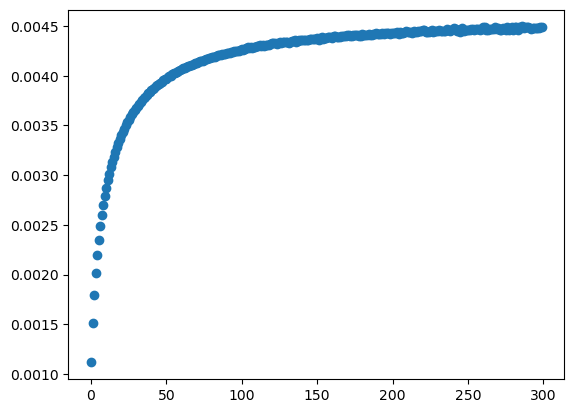

In [25]:
plt.scatter(range(300),error_S_squared)

In [ ]:
np.random.seed(43210)
iterations = 10**6
N=1001
start = time.time()
coord = initial_SAW(N)
end = time.time()
print("Dimerization time:", end - start)
ω_squared, S_squared,f = pivot_run(coord,iterations)


Dimerization time: 615.6446738243103


100%|██████████| 1000000/1000000 [27:12<00:00, 612.63it/s]


In [124]:
error_ω_squared,τ_int_bin_ω_squared  = binning_analyis(ω_squared,500)
error_S_squared,τ_int_bin_S_squared  = binning_analyis(S_squared,500)
uncorrelated_ω_squared = ω_squared[::τ_int_bin_ω_squared]
uncorrelated_S_squared = S_squared[::τ_int_bin_S_squared]
mean_ω_squared = np.mean(uncorrelated_ω_squared)
mean_S_squared = np.mean(uncorrelated_S_squared)
ur = mean_S_squared/mean_ω_squared


print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {error_ω_squared[-1]}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {error_S_squared[-1]}")
print(f"Universal ratio is: {ur}")
print(f"Acceptance rate f = ",f)

Mean squared end-to-end distance is: 24433.16705416473 ± 88.26524734891058
Mean squared gyration radius is: 3424.6538098759547 ± 10.090815030068034
Universal ratio is: 0.14016413845507633
Acceptance rate f =  0.253896


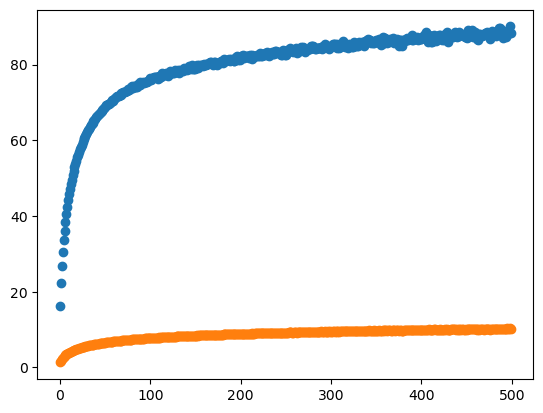

In [ ]:
plt.scatter(range(500),error_ω_squared)
plt.scatter(range(500),error_S_squared)

# Simulations

In [ ]:
#Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001]
#seeds = np.arrayarray([2781300983, 552437507, 239163331, 1112836520, 1562221245, 4039863786,  930428319, 4185896816, 2716273418, 4265127893, 432287740, 2672218962, 3546297565])
Ns = [16,21]
seeds = np.array([2790077416, 1086981728])
iterations = 10**6
binning_max = 200
times = np.zeros((2,len(Ns)))
ω_squareds = np.zeros((len(Ns),iterations))
S_squareds = np.zeros((len(Ns),iterations))
error_ω_squareds = np.zeros((len(Ns),binning_max))
error_S_squareds = np.zeros((len(Ns),binning_max))
autocorr_time_ω_squareds = np.zeros(len(Ns))
autocorr_time_S_squareds = np.zeros(len(Ns))
debug = 0

for i,N in enumerate(Ns):
    np.random.seed(seeds[i])
    accepted = np.zeros((2,7))
    start = time.time()
    coord = initial_SAW(N)
    end = time.time()
    ω_squared, S_squared, accepted = pivot_run(coord,iterations)
    end_total = time.time()
    ω_squareds[i,:] = ω_squared
    S_squareds[i,:] = S_squared

    times[0,i] = end-start
    times[1,i] = end_total-start

    np.save(f"accepted{N}.npy",accepted)

    error_ω_squared, autocorr_time_ω_squared = binning_analyis(ω_squared,binning_max)
    error_S_squared, autocorr_time_S_squared = binning_analyis(S_squared,binning_max)
    error_ω_squareds[i,:] = error_ω_squared
    error_S_squareds[i,:] = error_S_squared
    autocorr_time_ω_squareds[i] = autocorr_time_ω_squared
    autocorr_time_S_squareds[i] = autocorr_time_S_squared
    

    plt.xlabel("Binning level")
    plt.ylabel("Error")
    plt.grid()
    plt.scatter(range(binning_max),error_ω_squared,label="Squared end-to-end distance")
    plt.scatter(range(binning_max),error_S_squared,label="Squared radius of gyration")
    plt.legend()
    plt.savefig(f"Binning_analysis{N}.png")
    plt.close()


np.save("ω_squareds.npy",ω_squareds)
np.save("S_squareds.npy",S_squareds)
np.save("times.npy",times)
np.save("error_ω_squareds.npy",error_ω_squareds)
np.save("error_S_squareds.npy",error_S_squareds)
np.save("autocorr_time_ω_squared.npy",autocorr_time_ω_squareds)
np.save("autocorr_time_S_squared.npy",autocorr_time_S_squareds)



# Results and Analysis

In [26]:
#Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001,5001,6001,7001,8001,9001,10001]
Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001]
ω_squareds = np.load("results/ω_squareds.npy")
S_squareds = np.load("results/S_squareds.npy")
error_ω_squareds = np.load("results/error_ω_squareds.npy")[:,-1]
error_S_squareds = np.load("results/error_S_squareds.npy")[:,-1]
autocorr_time_ω_squareds=np.load("results/autocorr_time_ω_squared.npy")
autocorr_time_S_squareds=np.load("results/autocorr_time_S_squared.npy")
times = np.load("results/times.npy")
mean_ω_squareds=[]
mean_S_squareds=[]
fs = []
for i,N in enumerate(Ns):
    ω_squared = ω_squareds[i,:]
    S_squared = S_squareds[i,:]
    #error_ω_squared = error_ω_squareds[i,:]
    #error_S_squared = error_S_squareds[i,:]
    autocorr_time_ω_squared = autocorr_time_ω_squareds[i]
    autocorr_time_S_squared = autocorr_time_S_squareds[i]

    mean_ω_squared = np.mean(ω_squared)
    mean_ω_squareds.append(mean_ω_squared)
    mean_S_squared = np.mean(S_squared)
    mean_S_squareds.append(mean_S_squared)

    ur = mean_S_squared/mean_ω_squared
    accepted = np.load(f"results/accepted{N}.npy")
    f = np.sum(accepted[0,:])/np.sum(accepted[1,:])
    fs.append(f)
    


    print(f"Results for N = {N}:")
    print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {error_ω_squareds[i]}")
    print(f"Mean squared gyration radius is: {mean_S_squared} ± {error_S_squareds[i]}")
    print(f"Universal ratio ur = {ur}")
    print(f"Acceptance rate f = ",f)
    print(f"Autocorrelation time ω^2 = ",autocorr_time_ω_squared)
    print(f"Autocorrelation time S^2 = ",autocorr_time_S_squared )
    print(f"Total simulation time [s] = {times[1,i]}")
    print(f"From that: Dimerisation time [s] = {times[0,i]}")
    print()
          

Results for N = 101:
Mean squared end-to-end distance is: 779.531542 ± 2.119077110310787
Mean squared gyration radius is: 109.20901555376922 ± 0.23832078599091475
Universal ratio ur = 0.14009569808243785
Acceptance rate f =  0.398538
Autocorrelation time ω^2 =  7.947150653165174
Autocorrelation time S^2 =  16.485963127238517
Total simulation time [s] = 392.278107881546
From that: Dimerisation time [s] = 0.13713550567626953

Results for N = 201:
Mean squared end-to-end distance is: 2184.677104 ± 6.862774641783204
Mean squared gyration radius is: 306.215909992723 ± 0.7958037003173813
Universal ratio ur = 0.1401652946479193
Acceptance rate f =  0.347684
Autocorrelation time ω^2 =  10.766281082055999
Autocorrelation time S^2 =  23.10719460197443
Total simulation time [s] = 749.9023852348328
From that: Dimerisation time [s] = 0.6528449058532715

Results for N = 401:
Mean squared end-to-end distance is: 6163.314806 ± 20.433018066857063
Mean squared gyration radius is: 867.1136797441562 ± 2.2

# Critical Exponents

Critical exponent p = 0.196558
A = 0.986632
R-squared: 0.999948


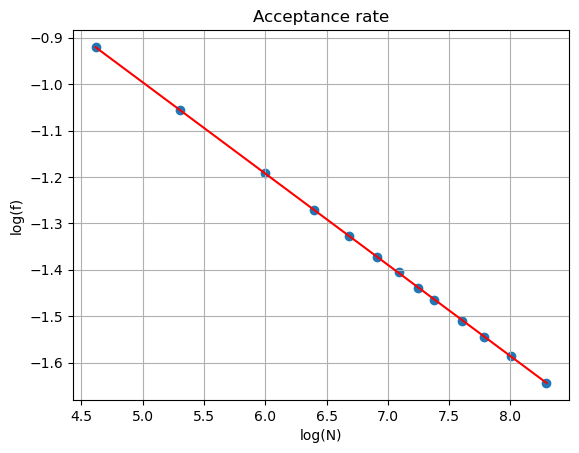

In [45]:
from scipy import stats
x = np.log(Ns)
y = np.log(fs)

plt.scatter(x,y)
res = stats.linregress(x, y)
plt.xlabel("log(N)")
plt.ylabel("log(f)")
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
plt.grid()
plt.title("Acceptance rate")
print(f"Critical exponent p = {-res.slope:.6f}")
print(f"A = {np.exp(res.intercept):.6f}")
print(f"R-squared: {res.rvalue**2:.6f}")

In [ ]:
def polynomial(x,a,b):
    return a*x**b
poptω_squareds, pcovω_squareds = curve_fit(polynomial, Ns, mean_ω_squareds)
poptS_squareds, pcovS_squareds = curve_fit(polynomial, Ns, mean_S_squareds)

popt_autocorr_ω, pcov_autcorr_ω = curve_fit(polynomial, Ns, autocorr_time_ω_squareds)
popt_autocorr_ω, pcov_autcorr_ω = curve_fit(polynomial, Ns, autocorr_time_ω_squareds)



In [ ]:
plt.scatter(Ns,mean_ω_squareds)
plt.xlabel("N")
plt.ylabel(r"$\langle \omega^2 \rangle$")
plt.plot(range(10000),polynomial(range(10000),poptω_squareds[0],poptω_squareds[1]), label=fr'A = {poptω_squareds[0]:.4f} = /n \nu = {poptω_squareds[1]/2:.4f}')
plt.grid()
plt.title("Acceptance rate")
print(f"Critical exponent \nu = {poptω_squareds[1]/2:.4f}")

In [13]:
np.linspace(0,10000)

array([    0.        ,   204.08163265,   408.16326531,   612.24489796,
         816.32653061,  1020.40816327,  1224.48979592,  1428.57142857,
        1632.65306122,  1836.73469388,  2040.81632653,  2244.89795918,
        2448.97959184,  2653.06122449,  2857.14285714,  3061.2244898 ,
        3265.30612245,  3469.3877551 ,  3673.46938776,  3877.55102041,
        4081.63265306,  4285.71428571,  4489.79591837,  4693.87755102,
        4897.95918367,  5102.04081633,  5306.12244898,  5510.20408163,
        5714.28571429,  5918.36734694,  6122.44897959,  6326.53061224,
        6530.6122449 ,  6734.69387755,  6938.7755102 ,  7142.85714286,
        7346.93877551,  7551.02040816,  7755.10204082,  7959.18367347,
        8163.26530612,  8367.34693878,  8571.42857143,  8775.51020408,
        8979.59183673,  9183.67346939,  9387.75510204,  9591.83673469,
        9795.91836735, 10000.        ])